In [ ]:
# python -m venv gpt-env
# .\gpt-env\Scripts\Activate.ps1
# pip3 install -r requirements.txt
# pip3 install torch --index-url https://download.pytorch.org/whl/cu118

In [ ]:
import random
import gc
import shutil

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW

from transformers import AutoTokenizer, AutoModelForCausalLM, set_seed

from tqdm.auto import tqdm


torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
set_seed(0)
print(torch.cuda.is_available())

True


In [ ]:
DEVICE = "cuda"
MODEL_NAME = "ai-forever/rugpt3medium_based_on_gpt2"
BOS_TOKEN = "<s>"
EOS_TOKEN = "</s>"
MAX_LENGTH = 850
NUM_EPOCHS = 5
TEST_SPLIT_SIZE=0.05
SCHEDULER_GAMMA = 0.7
TRAIN_BATCH_SIZE = 3
TEST_BATCH_SIZE = 5
LEARNING_RATE = 5e-5
RESUMING = True

In [ ]:
# dataset
!gdown https://drive.google.com/uc?id=1MqOFMEg8CQ77oz4D0Iuaib9xF1w-DkIG

Downloading...
From: https://drive.google.com/uc?id=1MqOFMEg8CQ77oz4D0Iuaib9xF1w-DkIG
To: /content/important_polls_cleared_updated.csv
100% 20.3M/20.3M [00:00<00:00, 90.7MB/s]


In [ ]:
df = pd.read_csv("important_polls_cleared_updated.csv")
df

,id,question,answer1,answer2,rate1,rate2,votes1,votes2,src
0,885598345,Хотите ли вы детей?,Да,Нет,51.74,48.26,6926,6461,vso_1
1,966697749,Вы коллекционер монет. Однажды на барахолке по...,Продать монету. Друг будет всю жизнь считать м...,"Признаться, что монета поддельная",38.45,61.55,809,1295,vso_1
2,967001095,Вы изобрели революционное противозачаточное. В...,"Согласиться. Дама внушает доверие, но неизвест...",Отказаться и продолжить искать подопытных само...,86.80,13.20,848,129,vso_1
3,966790489,"Представим, что вас крупно подставили таким об...",Отдать мошеннику миллион рублей.,"Не давать мошеннику денег, но потратить на суд...",28.62,71.38,417,1040,vso_1
4,965896595,Вам заплатят 1 млн$ если вы переночуете в 100 ...,Согласиться,Отказаться,88.96,11.04,2344,291,vso_1
...,...,...,...,...,...,...,...,...,...
35309,262553004,,"всякий раз, знакомясь с противоположным полом,...",на протяжении пяти лет везде носить с собой тя...,72.05,27.95,7637,2962,2oprosa
35310,262552490,,"каждый раз, выходя из транспорта, непроизвольн...",до 13 часов дня с 7 утра разговаривать тихим п...,67.40,32.60,7894,3819,2oprosa
35311,262552246,,всю жизнь носить смешной костюм ватрушки,"поджечь детский дом, не зная, как развернутся ...",41.46,58.54,4719,6664,2oprosa
35312,262551792,,Читать со скоростью одна страница в секунду,Иметь возможность останавливать время на 10 ми...,16.45,83.55,2500,12700,2oprosa


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME).to(DEVICE)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/761 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.61M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

In [ ]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
print(
    f"Total mem = {t/1024/1024} Mb, Reserved = {r/1024/1024} Mb, Allocated = {a/1024/1024} Mb"
)

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   1453 MiB |   1453 MiB |   1453 MiB |      0 B   |
|       from large pool |   1452 MiB |   1452 MiB |   1452 MiB |      0 B   |
|       from small pool |      1 MiB |      1 MiB |      1 MiB |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |   1453 MiB |   1453 MiB |   1453 MiB |      0 B   |
|       from large pool |   1452 MiB |   1452 MiB |   1452 MiB |

In [ ]:
class PollsDataset(torch.utils.data.Dataset):
    def __init__(self, polls, p=0.5):
        self.polls = polls
        self.p = p

    def __getitem__(self, idx):
        row = self.polls.iloc[idx]
        question = row["question"].strip()
        if not question.strip(".").endswith("?"):
            question = question + "\nЧто бы Вы выбрали?"
        answer1 = row["answer1"]
        answer2 = row["answer2"]
        if np.random.rand() < self.p:
            answer1, answer2 = answer2, answer1
        return f"{BOS_TOKEN}{question}\n1. {answer1}\n2. {answer2}{EOS_TOKEN}"

    def __len__(self):
        return len(self.polls)


train_df, test_df = train_test_split(df, test_size=TEST_SPLIT_SIZE, random_state=0)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
train_dataset = PollsDataset(train_df)
test_dataset = PollsDataset(test_df)

In [ ]:
def collate_fn(batch):
    return tokenizer(batch, padding=True, truncation=True, return_tensors="pt", max_length=MAX_LENGTH)

def batch_sampling_fn(row):
    question = row["question"]
    answer1 = row["answer1"]
    answer2 = row["answer2"]
    return len(f"{question}{answer1}{answer2}")


class AccedingSequenceLengthBatchSampler(torch.utils.data.Sampler):
    def __init__(self, data, batch_size):
        self.sizes = torch.tensor(data.apply(batch_sampling_fn, axis=1, ))
        self.batch_size = batch_size

    def __len__(self):
        return (len(self.sizes) + self.batch_size - 1) // self.batch_size

    def __iter__(self):
        for batch in random.sample(
            list(torch.chunk(torch.argsort(self.sizes), len(self))), len(self)
        ):  # randomize
            yield batch.tolist()

In [ ]:
train_sampler = AccedingSequenceLengthBatchSampler(train_df, TRAIN_BATCH_SIZE)
train_dataloader = DataLoader(
    train_dataset, batch_sampler=train_sampler, collate_fn=collate_fn
)
test_sampler = AccedingSequenceLengthBatchSampler(test_df, TEST_BATCH_SIZE)
test_dataloader = DataLoader(
    test_dataset, batch_sampler=test_sampler, collate_fn=collate_fn
)

In [ ]:
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(
    optimizer, gamma=SCHEDULER_GAMMA
)
config = model.config

In [ ]:
def clear_memory():
    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
def train(losses):
    progress_bar = tqdm(range(len(train_dataloader)))
    model.train()
    for i, batch in enumerate(train_dataloader):
        if i % 4 == 0:
            clear_memory()
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits[:, :-1, :].reshape(-1, config.vocab_size)
        target = batch["input_ids"][:, 1:].flatten()

        loss = torch.nn.functional.cross_entropy(logits, target)

        losses.append(loss.item())
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        progress_bar.update(1)

def test():
    progress_bar = tqdm(range(len(test_dataloader)))
    losses = []
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(test_dataloader):
            if i % 4 == 0:
              clear_memory()
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits[:, :-1, :].reshape(-1, config.vocab_size)
            target = batch["input_ids"][:, 1:].flatten()

            # Compute loss
            loss = torch.nn.functional.cross_entropy(logits, target)
            losses.append(loss.item())
            progress_bar.update(1)
    return np.mean(losses)

In [ ]:
# для коллаба
from google.colab import drive
drive.mount("/content/drive")

# !cp -r /content/drive/MyDrive/finetuned_model_5 ./finetuned_model_5
# !cp -r /content/drive/MyDrive/scheduler_5 ./scheduler_5
# !cp -r /content/drive/MyDrive/optimizer_5 ./optimizer_5

def load_train_state(epoch: int):
    shutil.copy(
        f"/content/drive/MyDrive/finetuned_model_{epoch}",
        f"./finetuned_model_{epoch}",
    )
    shutil.copy(
        f"/content/drive/MyDrive/scheduler_{epoch}",
        f"./scheduler_{epoch}",
    )
    shutil.copy(
        f"/content/drive/MyDrive/optimizer_{epoch}",
        f"./optimizer_{epoch}",
    )
    model.load_state_dict(torch.load(f"./finetuned_model_{epoch}"))
    lr_scheduler.load_state_dict(torch.load(f"./scheduler_{epoch}"))
    optimizer.load_state_dict(torch.load(f"./optimizer_{epoch}"))


def save_train_state(epoch: int = 0):
    torch.save(model.state_dict(), f"./finetuned_model_{epoch}")
    shutil.copy(
        f"./finetuned_model_{epoch}",
        f"/content/drive/MyDrive/finetuned_model_{epoch}"
    )
    torch.save(lr_scheduler.state_dict(), f"./scheduler_{epoch}")
    shutil.copy(
        f"./scheduler_{epoch}",
        f"/content/drive/MyDrive/scheduler_{epoch}",
    )
    torch.save(optimizer.state_dict(), f"./optimizer_{epoch}")
    shutil.copy(
        f"./optimizer_{epoch}",
        f"/content/drive/MyDrive/optimizer_{epoch}",
    )

Mounted at /content/drive


In [ ]:
def save_model(epoch: int):
    model.save_pretrained(f"./finetuned_model_{epoch}")
    tokenizer.save_pretrained(f"./finetuned_model_{epoch}")

In [ ]:
test_loss = test()
print(f"\tTEST_LOSS = {test_loss}")

  0%|          | 0/354 [00:00<?, ?it/s]

	TEST_LOSS = 7.143330695938929


In [ ]:
train_losses = []
epoch_mean_losses = []
test_mean_losses = []

for epoch in range(1, NUM_EPOCHS+1):
    train(train_losses)
    epoch_loss = np.mean(train_losses[-len(train_dataloader):])
    epoch_mean_losses.append(epoch_loss)
    print(
        f"EPOCH {epoch} with step={lr_scheduler.get_last_lr()}: TRAIN LOSS = {epoch_loss}"
    )
    test_loss = test()
    test_mean_losses.append(test_loss)
    print(f"\tTEST_LOSS = {test_loss}")
    lr_scheduler.step()
    save_model(epoch)


  0%|          | 0/11183 [00:00<?, ?it/s]

EPOCH 1 with step=[5e-05]: TRAIN LOSS = 2.217592492178622


  0%|          | 0/354 [00:00<?, ?it/s]

	TEST_LOSS = 1.955548288795234


  0%|          | 0/11183 [00:00<?, ?it/s]

EPOCH 2 with step=[3.5e-05]: TRAIN LOSS = 1.6683977615702166


  0%|          | 0/354 [00:00<?, ?it/s]

	TEST_LOSS = 1.8143286703333343


  0%|          | 0/11183 [00:00<?, ?it/s]

EPOCH 3 with step=[2.4499999999999996e-05]: TRAIN LOSS = 1.329318496725336


  0%|          | 0/354 [00:00<?, ?it/s]

	TEST_LOSS = 1.7932201405029513


  0%|          | 0/11183 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
clear_memory()

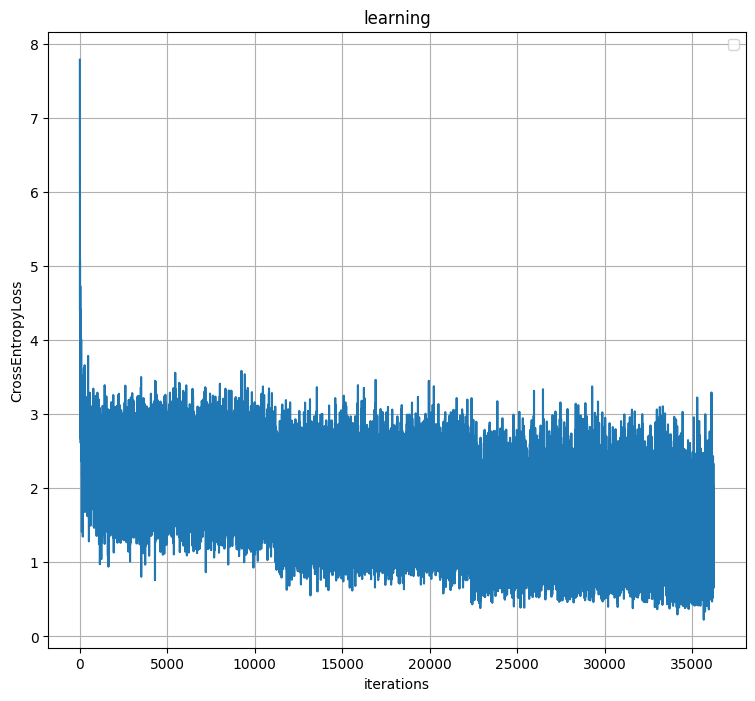

In [ ]:
plt.figure(figsize=(9, 8))
plt.title("learning")
plt.xlabel(f"iterations")
plt.ylabel("CrossEntropyLoss")
plt.plot(train_losses)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
save_model(35)

In [ ]:
!cp -r ./finetuned_model_3 /content/drive/MyDrive/finetuned_model_medium_33

In [ ]:
test_loss = test()
print(f"\tTEST_LOSS = {test_loss}")

  0%|          | 0/354 [00:00<?, ?it/s]

	TEST_LOSS = 1.8461797557308175


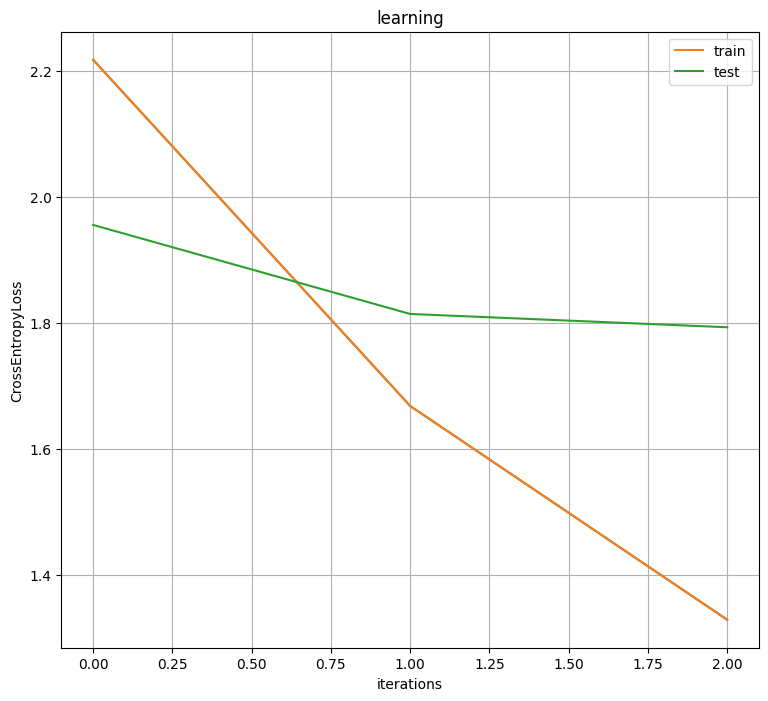

In [ ]:
plt.figure(figsize=(9, 8))
plt.title("learning")
plt.xlabel(f"iterations")
plt.ylabel("CrossEntropyLoss")
plt.plot(epoch_mean_losses)
plt.plot(epoch_mean_losses, label='train')
plt.plot(test_mean_losses, label='test')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.eval()
model_inputs = tokenizer("<s>", return_tensors="pt").to(DEVICE)

In [ ]:
max_new_tokens = 200

In [ ]:
# greedy sampling
greedy_output = model.generate(**model_inputs, max_new_tokens=max_new_tokens)

print("Output:\n" + 100 * "-")
print(tokenizer.decode(greedy_output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------

Что бы Вы выбрали?
1. Вы можете силой мысли менять цвет любого предмета, который вы захотите.
2. Вы можете силой мысли менять цвет любого предмета, который вы захотите.


In [ ]:
# beam sampling
outputs = model.generate(
    **model_inputs,
    max_new_tokens=max_new_tokens,
    num_beams=5,
    num_return_sequences=5,
    early_stopping=True
)

for i, output in enumerate(outputs):
    print("Output:\n" + 100 * "-")
    print(
        "{}".format(tokenizer.decode(output, skip_special_tokens=True))
    )

Output:
----------------------------------------------------------------------------------------------------

Что бы Вы выбрали?
1. У вас в квартире поселяется кот.
2. У вас в квартире поселяется кот.
Output:
----------------------------------------------------------------------------------------------------

Что бы Вы выбрали?
1. У вас в квартире поселяется кот.
2. У вас в квартире поселяется собака.
Output:
----------------------------------------------------------------------------------------------------

Что бы Вы выбрали?
1. У вас в квартире поселяется кот.
2. У вас в квартире поселяется котик.
Output:
----------------------------------------------------------------------------------------------------

Что бы Вы выбрали?
1. У вас в квартире поселяется кот.
2. У вас в квартире поселяется кошка.
Output:
----------------------------------------------------------------------------------------------------

Что бы Вы выбрали?
1. У вас появляется возможность превращаться в кота.
2. У ва

In [ ]:
# no repeat n-gram
outputs = model.generate(
    **model_inputs,
    max_new_tokens=max_new_tokens,
    num_beams=5,
    no_repeat_ngram_size=3,
    num_return_sequences=5,
    early_stopping=True
)

for i, output in enumerate(outputs):
    print("Output:\n" + 100 * "-")
    print(
        "{}".format(tokenizer.decode(output, skip_special_tokens=True))
    )

Output:
----------------------------------------------------------------------------------------------------

Что бы Вы выбрали?
1. У вас появляется возможность превращаться в кота.
2. Вы можете превращаться во змею.
Output:
----------------------------------------------------------------------------------------------------

Что бы Вы выбрали?
1. У вас появляется возможность превращаться в кота.
2. Вы можете превращать людей в котов.
Output:
----------------------------------------------------------------------------------------------------

Что бы Вы выбрали?
1. У вас появляется возможность превращаться в кота.
2. Вы можете превращаться во льва.
Output:
----------------------------------------------------------------------------------------------------

Что бы Вы выбрали?
1. У вас появляется возможность превращаться в кота.
2. Вы можете превращать людей в кошек.
Output:
----------------------------------------------------------------------------------------------------

Что бы Вы выбр

In [ ]:
# activate sampling and deactivate top_k by setting top_k sampling to 0
outputs = model.generate(
    **model_inputs,
    max_new_tokens=max_new_tokens,
    do_sample=True,
    top_k=0,
    num_return_sequences=5,
)

for i, output in enumerate(outputs):
    print("Output:\n" + 100 * "-")
    print(
        "{}".format(tokenizer.decode(output, skip_special_tokens=True))
    )

Output:
----------------------------------------------------------------------------------------------------

Что бы Вы выбрали?
1. Стать мастерством каким-нибудь снайпером
2. Получить доступ к самым важным документам вашего родного государства
Output:
----------------------------------------------------------------------------------------------------

Что бы Вы выбрали?
1. Вы по щелчку можете изменять некоторые параметры: разрешение экрана, температуру, и т.д. способами, которые подобны те, которыми пользуются в компьютерной игре.
2. Вы можете двигать в помещении взглядом до тех пор, пока не начнететельный интересоваться чем-то новым незнакомым. Изменить ничего нельзя.
Output:
----------------------------------------------------------------------------------------------------

Что бы Вы выбрали?
1. Отсидеть 2 года дома и ничего не заработать
2. Отсидеть 5 лет дома в первом РЭУ за 200 000$ и 6 сумароков
Output:
---------------------------------------------------------------------------

In [ ]:
# with temperature
outputs = model.generate(
    **model_inputs,
    max_new_tokens=max_new_tokens,
    do_sample=True,
    top_k=0,
    temperature=1.2,
    num_return_sequences=5,
)

for i, output in enumerate(outputs):
    print("Output:\n" + 100 * "-")
    print(
        "{}".format(tokenizer.decode(output, skip_special_tokens=True))
    )

Output:
----------------------------------------------------------------------------------------------------

Что бы Вы выбрали?
1. Устроить себе спиральную пицце в микроволновке ECS (75$ на вашу карточку, 8 часов сна гарантированы)
2. Съесть пиццу чи там или отпрыгивать просмотры максимального фузЗи-101 и квадратами сыра исключительно (ано-нельзя делать аборты, быть детьми порно притягательнее минусовикинымящего отвзячивостьби census цитировалось 101 русскими / 140 английским
Output:
----------------------------------------------------------------------------------------------------

Что бы Вы выбрали?
1. возможность отправил чужой любимым символов.
2. по вашему желанию вы забыли ведро у себя из рук.
Output:
----------------------------------------------------------------------------------------------------

Что бы Вы выбрали?
1. Чоп на. рваные джинсы, с высокой скидкой этом сезоне и куртке которая разбивалась, бахилы для купания
2. Огромный пакет, баночки бонусов стоимостью 50 тысяч 

In [ ]:
# top k
outputs = model.generate(
    **model_inputs,
    max_new_tokens=max_new_tokens,
    do_sample=True,
    top_k=50,
    num_return_sequences=5,
    no_repeat_ngram_size=3,
)

for i, output in enumerate(outputs):
    print("Output:\n" + 100 * "-")
    print(
        "{}".format(tokenizer.decode(output, skip_special_tokens=True))
    )

Output:
----------------------------------------------------------------------------------------------------

Что бы Вы выбрали?
1. Все ваши друзья теперь носят одежду с принтом вашей любимой группы.
2. Все ваш знакомые люди теперь носят ту одежду, которая была у вас, но она не приносит с собой никакой пользы.
Output:
----------------------------------------------------------------------------------------------------

Что бы Вы выбрали?
1. Теперь каждый день перед вами стоит выбор: выпить 5 стаканов газировки за один раз, если не выплюнете это и допьете сами, или 50 стаканов воды за один день. Нельзя пить больше четырех стаканов за каждый день.
2. Каждый день в вашем холодильнике появляется случайная вещь рандомного качества, но очень дорогого. Например: килограмм шоколадного плова, в котором вы будете нуждаться на всю жизнь, или два больших стакана колы, которую вы пьете очень-очень часто, или 5 стаконов колы. Забирать эту вещь нельзя.
Output:
-----------------------------------------

In [ ]:
# top p
outputs = model.generate(
    **model_inputs,
    max_new_tokens=max_new_tokens,
    do_sample=True,
    top_p=0.92,
    top_k=0,
    num_return_sequences=5,
    no_repeat_ngram_size=4,
)

for i, output in enumerate(outputs):
    print("Output:\n" + 100 * "-")
    print(
        "{}".format(tokenizer.decode(output, skip_special_tokens=True))
    )

Output:
----------------------------------------------------------------------------------------------------

Что бы Вы выбрали?
1. 10000 рублей наличными, которые вы можете потратить только в России
2. 5 миллионов рублей наличными
Output:
----------------------------------------------------------------------------------------------------

Что бы Вы выбрали?
1. На Windows автоматически закрывают все аккаунты во всех соц. сетях
2. Теперь, если вы хоть сколько-нибудь приглядитесь к экрану - вы увидите каждый URL на Ютубе
Output:
----------------------------------------------------------------------------------------------------

Что бы Вы выбрали?
1. Вы больше не знаете, когда ваша вторая половинка что-то хочет или заигрывает, а с ней вместе это невозможно
2. Вы больше никогда не увидите и не услышите, о чем люди говорят. Повсюду, кроме вас, этого не происходит
Output:
----------------------------------------------------------------------------------------------------

Что бы Вы выбрали?

In [ ]:
# topk + topp.
sample_outputs = model.generate(
    **model_inputs,
    max_new_tokens=max_new_tokens,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    no_repeat_ngram_size=4,
    num_return_sequences=3,
)

for i, sample_output in enumerate(sample_outputs):
    print("Output:\n" + 100 * "-")
    print(
        "{}: {}".format(
            i, tokenizer.decode(sample_output, skip_special_tokens=True)
        )
    )

Output:
----------------------------------------------------------------------------------------------------
0: 
Что бы Вы выбрали?
1. Вам по вашему желанию дают билет на путешествие в Антарктиду. Вы будете постоянно на солнце, можете дышать под водой, вас будет сопровождать опытный дайвер и много других специалистов.
2. Вам дают два билета на поездку в космос. Вы можете дышать под землёй, вы сможете прожить там до старости. Но если вы умрете раньше чем через 1 год, ваши похоронят с почестями, не будет места где бы вы не провели всю жизнь.
Output:
----------------------------------------------------------------------------------------------------
1: 
Что бы Вы выбрали?
1. на улице вы можете видеть абсолютно всех птиц в мире
2. никогда больше не выпускать изо рта семечко
Output:
----------------------------------------------------------------------------------------------------
2: 
Что бы Вы выбрали?
1. Вы можете превращаться в человека, который сидит в библиотеке и читает книгу, у вас 